In [1]:
import torch
import re, pickle, collections, numpy as np, keras, math, operator, pdb
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torchvision.models import inception_v3
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import re
from os import path
from glob import glob
from torch.utils.data import DataLoader
from PIL import Image
from data_loader import get_loader
from build_vocab import build_vocab
from encoder import Encoder
from torch.nn.utils.rnn import pack_padded_sequence
from utils import *
from create_emb_matrix import create_emb_mat
from decoder import LSTMDecoder
from tqdm import tnrange, tqdm_notebook
import pdb
%load_ext autoreload
%autoreload 2


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5103, 7003))
/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [6]:
#dpath = '/data/image_captioning/flikr8/'
dpath = 'flikr8/'

img_path = dpath+'Flicker8k_Dataset/'
tr_img_path = img_path +'train/wrap'
dev_img_path = img_path +'dev/wrap'
#samp_tr_img_path = imgpath + 'samp/train/wrap/'
MODEL_PREFIX = 'mult_caps'
embed_path = dpath+'glove.6B.100d.txt'
#embed_path = '/data/word_embed/glove.6B.100d.txt'

glove_dict_path = dpath+'glove.6B.100d_dict.pkl'
BATCH_SIZE = 2
emb_size= 100

In [3]:
tr_caps = pickle.load(open(dpath+'train_all_caps.pkl', 'rb'))
dev_caps = pickle.load(open(dpath+'dev_all_caps.pkl', 'rb'))
#all_caps = pickle.load(open(dpath+'all_caps.pkl', 'rb'))

vocab = build_vocab(tr_caps, 0)

In [4]:
len(vocab.idx2word)

7708

In [7]:
emb_mat, found = create_emb_mat(vocab, embed_path=embed_path, glove_dict_path=glove_dict_path, dim_em=emb_size)

In [13]:
enc = Encoder(batch_size=BATCH_SIZE, emb_size=emb_size, pool_size=8, fc_in_size=2048, dropout=0.9)
dec = LSTMDecoder(len(vocab), emb_size, 1, dropout=0.9, pre_tr_emb=emb_mat)

if torch.cuda.is_available(): 
    enc.cuda()
    dec.cuda()

LR = 0.001
params = list(dec.lstm.parameters()) + list(dec.linear.parameters()) + list(enc.linear.parameters()) + list(enc.bn.parameters())
optimizer = torch.optim.Adam(params, lr=LR)


In [11]:
def validate_dev(enc, dec, dev_caps=dev_caps, dev_img_path=dev_img_path, batch_size=BATCH_SIZE):
    enc.eval(); dec.eval()
    crit = nn.CrossEntropyLoss()
    dl = get_loader(dev_img_path, dev_caps, vocab, batch_size=batch_size, shuffle=True, num_workers=1)
    
    tot_loss = 0.0
    for i, (imgs, caps, ls) in enumerate(dl):
        #dl.dataset.sanity(imgs, caps, ls)
        #pdb.set_trace()
        imgs = to_var(imgs, volatile=True); caps = to_var(caps) #VOLATILE ON IMGS MAYBE?
        targets = pack_padded_sequence(caps, ls, batch_first=True)[0]
        imgs_enc = enc(imgs)

        out = dec(imgs_enc, caps, ls)
        loss = crit(out, targets)
        tot_loss += loss
    enc.train(); dec.train()
    return tot_loss.data[0] / i

In [14]:
crit = nn.CrossEntropyLoss()

for epoch in range(1000):
    dl = get_loader(tr_img_path, tr_caps, vocab, transform=tr_trans, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)
    best_loss = 1000.0
    tot_loss = 0.0
    for i, (imgs, caps, ls) in enumerate(dl):
        optimizer.zero_grad()
        
        #dl.dataset.sanity(imgs, caps, ls)
        #pdb.set_trace()
        imgs = to_var(imgs, volatile=True); caps = to_var(caps) #VOLATILE ON IMGS MAYBE?
        targets = pack_padded_sequence(caps, ls, batch_first=True)[0]
        imgs_enc = enc(imgs)

        out = dec(imgs_enc, caps, ls)
        loss = crit(out, targets)
        loss.backward()
        tot_loss += loss
        optimizer.step()
    avg_tr_loss = tot_loss.data[0] / (i +1)
    print('epoch {} avg. tr loss: {}'.format(epoch, avg_tr_loss))
    if (epoch + 1) % 1 == 0:
        avg_val_loss =  validate_dev(enc, dec)
        print('epoch {} avg val loss: {}'.format(epoch, avg_val_loss))
        if avg_val_loss < best_loss:
            torch.save(enc.state_dict(), 'models/enc_{}.pt'.format(MODEL_PREFIX))
            torch.save(dec.state_dict(), 'models/dec_{}.pt'.format(MODEL_PREFIX))
            torch.save(optimizer.state_dict(), 'models/opt_{}.pt'.format(MODEL_PREFIX))
            best_loss = avg_val_loss
    

epoch 0 avg. tr loss: 3.9598606770833333
epoch 0 avg val loss: 3.6785639149392537
epoch 1 avg. tr loss: 3.1569456380208334
epoch 1 avg val loss: 3.6730166876722192
epoch 2 avg. tr loss: 3.4038522135416667
epoch 2 avg val loss: 3.3799557122056614
epoch 3 avg. tr loss: 2.84441796875
epoch 3 avg val loss: 3.484895327764905
epoch 4 avg. tr loss: 3.0405423177083333
epoch 4 avg val loss: 3.3211826485001255
epoch 5 avg. tr loss: 2.8334085286458333
epoch 5 avg val loss: 3.348826070108968
epoch 6 avg. tr loss: 3.008592122395833
epoch 6 avg val loss: 3.0898919420872994
epoch 7 avg. tr loss: 2.7143546549479165
epoch 7 avg val loss: 3.304749880620616
epoch 8 avg. tr loss: 3.0081741536458333
epoch 8 avg val loss: 3.189027224370616
epoch 9 avg. tr loss: 2.8045826822916666
epoch 9 avg val loss: 3.122237150081413
epoch 10 avg. tr loss: 2.6467928059895836
epoch 10 avg val loss: 3.4076018247432365
epoch 11 avg. tr loss: 2.51522607421875
epoch 11 avg val loss: 3.4642519903087425
epoch 12 avg. tr loss: 3.

Process Process-33:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 46, in _worker_loop
    data_queue.put((idx, samples))
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/multiprocessing/queues.py", line 348, in put
    obj = _ForkingPickler.dumps(obj)
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 113, in reduce_storage
    fd, size = storage._share_fd_()


### Train Sampling

<start> a man in an orange vest and hat is shoveling rocks while another man in a yellow and blue jacket looks on . <end>
caption length: 25
caption computed length: 25


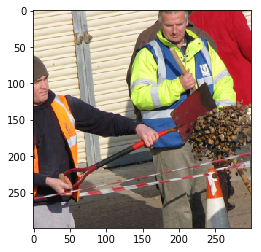

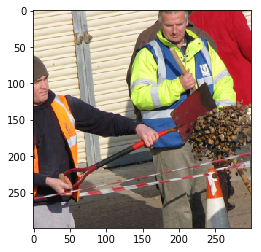

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a man in an orange vest and hat is shoveling rocks while another man in a yellow and blue jacket looks on . <end>


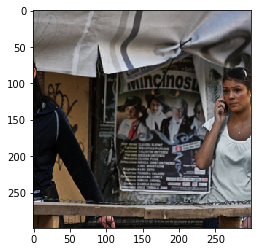

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a woman in white and woman in black are standing by each other talking on cellphones . <end> <pad> <pad> <pad> <pad> <pad> <pad>


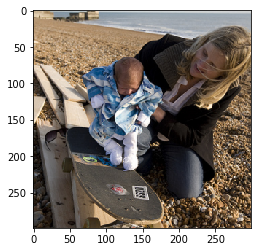

Predicted: <start> a boy in a red shirt and white shorts is playing with a red ball . <end> <end> on
True: <start> a woman holding and posing an infant dressed in a hawaiin shirt on a skateboard . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


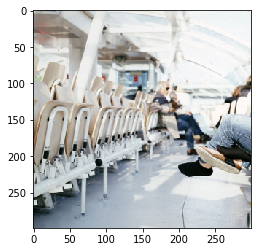

Predicted: <start> a man in a black and white shirt is sitting on a bench . <end> <end> . <end> <end>
True: <start> a couple of people sit in chairs in a waiting room lit in sunlight . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


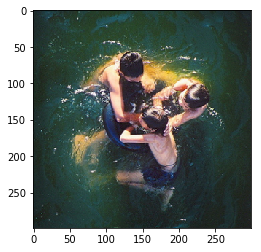

Predicted: <start> a man in a red shirt is climbing a rock face . <end> <end> <end> . <end> <end> <end>
True: <start> the three boys are all holding onto a flotation device in the water . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


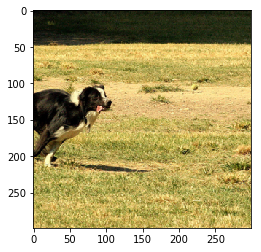

Predicted: <start> a black and white dog is jumping in the air while balancing a brown dog in a grassy field
True: <start> a black and white dog is chasing a ball on an open plane . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


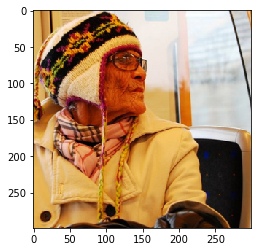

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a lady with glasses and a warm hat looks int other distance . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


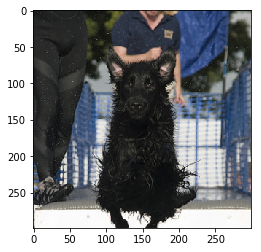

Predicted: <start> a black dog is jumping over a hurdle . <end> <end> <end> . <end> <end> . <end> <end> .
True: <start> a black dog is in midair as a woman behind it cheers . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


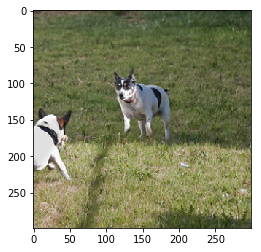

Predicted: <start> a black and white dog is jumping in the air while balancing a brown dog in a grassy field
True: <start> two black and white dogs running towards each other in the grass <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


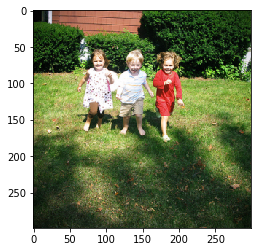

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> three little children in a grassy yard running towards the camera . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


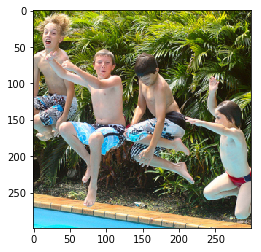

Predicted: <start> a boy in a red shirt and blue jeans is standing on a rock next to a man in
True: <start> four boys doing a cannonball jump in unison into the pool . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


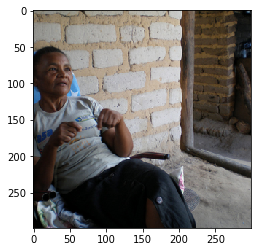

Predicted: <start> a man in a blue shirt with a blue shirt is looking at his cellphone . <end> <end> .
True: <start> a woman is sitting in a chair near a brick building . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


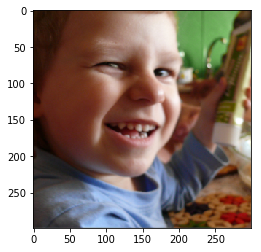

Predicted: <start> a girl in a pink dress is jubilant while a woman is sitting on her head . <end> <end>
True: <start> a boy holding a tube and smiling at the camera . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


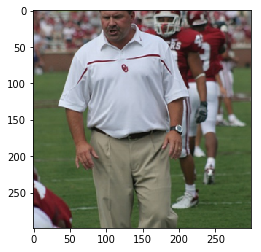

Predicted: <start> a man in a yellow shirt and a black dog are jumping on the beach with a brown dog
True: <start> a coach in a white polo shirt on a football field <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


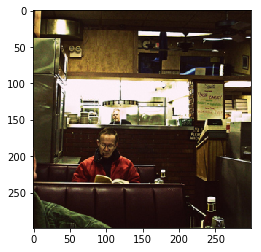

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a man sits alone in a diner reading a book . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


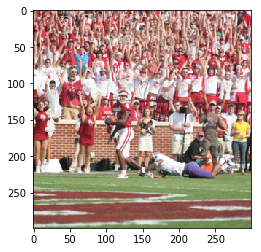

Predicted: <start> a group of people are riding on a roller coaster . <end> <end> <end> . <end> <end> . <end>
True: <start> a crowd is standing and cheering at a football game . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


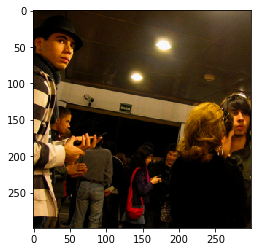

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a group of young people stand around waiting for something . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


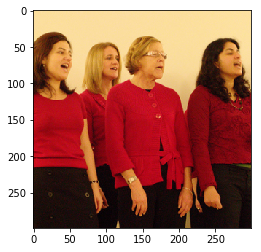

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a group of woman in red shirts are singing . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


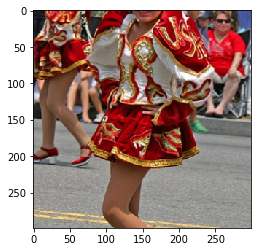

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a girl in a costume participates in a parade . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


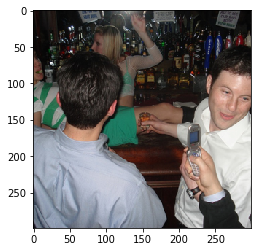

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a couple guys taking body shots off of a girl <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


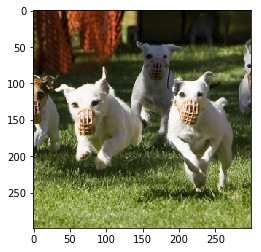

Predicted: <start> a black and white dog is jumping in the air while balancing a brown dog in a grassy field
True: <start> five small white dogs are wearing muzzles and running . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


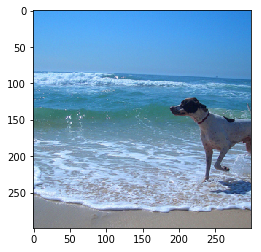

Predicted: <start> a brown dog is running on the beach . <end> <end> <end> . <end> . <end> <end> . <end>
True: <start> a dog playing in the ocean on the beach . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


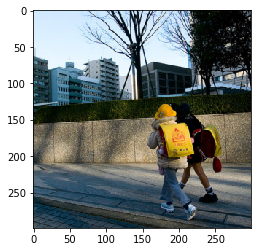

Predicted: <start> a boy in a red shirt and white shorts is playing with a red ball . <end> <end> on
True: <start> children walking on a sidewalk with yellow backpacks . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


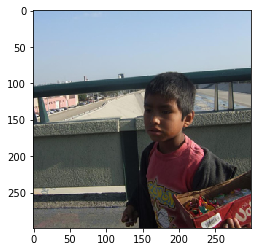

Predicted: <start> a boy in a red shirt and white shorts is playing with a red ball . <end> <end> on
True: <start> a boy carries a box across a bridge . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


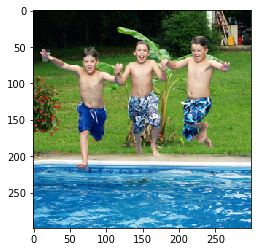

Predicted: <start> a boy in a red shirt and blue jeans is standing on a rock overlooking a mountain . <end>
True: <start> three boys leaping into a swimming pool . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


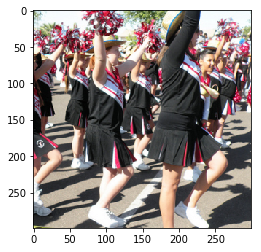

Predicted: <start> a group of people are standing in front of a building <end> a woman . <end> <end> . <end>
True: <start> a bunch of girls in cheerleader outfits . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


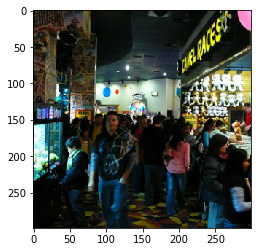

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a man walks through an arcade . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


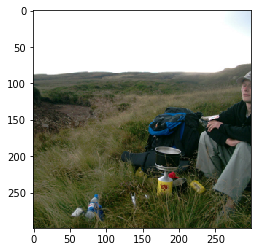

Predicted: <start> a man in a red shirt is climbing a rock face . <end> <end> <end> . <end> <end> .
True: <start> a hiker resting in a field . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


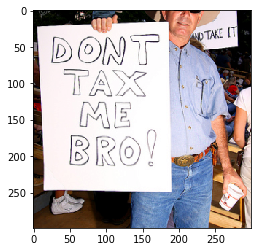

Predicted: <start> a man in a black shirt is sitting on a bench . <end> <end> to . <end> <end> .
True: <start> a man holding a political sign . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


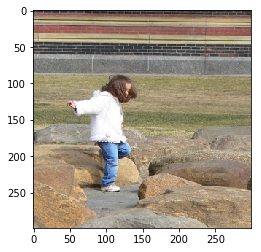

Predicted: <start> a boy in a red shirt and blue jeans is standing on a rock overlooking a mountain . <end>
True: <start> a child walking on rocks . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


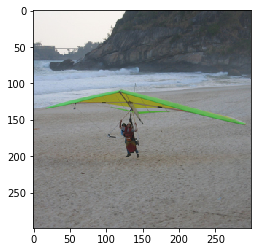

Predicted: <start> a man in a red shirt is climbing a rock face . <end> <end> <end> . <end> <end> <end>
True: <start> a person in a hang-glider . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


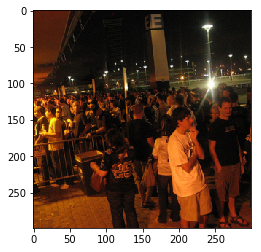

Predicted: <start> a group of people are standing in front of a building <end> a woman . <end> <end> . <end>
True: <start> a crowd of people . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [15]:
dl = get_loader(tr_img_path, tr_caps, vocab, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
imgs, preds, true = sampleBatch(enc, dec, dl)
displaySamples(imgs, preds, true, vocab)

### Dev sampling

In [13]:
dev_caps = pickle.load(open(dpath+'dev_first_caps.pkl', 'rb'))

In [ ]:
dl = get_loader(dev_img_path, dev_caps, vocab, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
imgs, caps = sampleBatch(enc, dec, dl)
displaySamples(imgs, caps, vocab)

### Dev Loss